In [41]:
import psycopg2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from datetime import datetime, timedelta
from pmdarima import auto_arima
from datetime import timedelta



ALTO URUGUAI CATARINENSE

In [42]:

conexao = psycopg2.connect(
    database="*******",
    user="*******",
    password="*******",
    host="*******",
    port="****"
)

cursor = conexao.cursor()

consulta = """
SELECT
    CAST(n.dt_notificacao as DATE) as data_notificacao,
    is2."regiao_cib184/2021asc" ,
    COUNT(1) as quantidade_casos
FROM sinan.notificacao n
LEFT JOIN public.semana_epidemiologica_datas sed ON sed."Data"  = n.dt_notificacao
left join ibge.ibge_sc is2 on is2.cod_ibge_6::text = n.cd_ibge_paciente::text
where
    n.de_agravo_cid = 'Dengue'
    and n.de_classificacao_final <> 'Descartado'
    and substring(n.cd_ibge_paciente, 1, 2) = '42'
group by is2."regiao_cib184/2021asc", data_notificacao
order by is2."regiao_cib184/2021asc", data_notificacao
"""

In [43]:

cursor.execute(consulta)

resultados = cursor.fetchall()

data = pd.DataFrame(resultados, columns=[desc[0] for desc in cursor.description])

data.rename(columns={'regiao_cib184/2021asc': 'regiao'}, inplace=True)


data['data_notificacao'] = pd.to_datetime(data['data_notificacao'], format='%Y-%m')



In [44]:
altouruguai = data[data['regiao']=='ALTO URUGUAI CATARINENSE']
valeitajai = data[data['regiao']=='ALTO VALE DO ITAJAÍ']
carbonifera = data[data['regiao']=='CARBONÍFERA']
extremooeste = data[data['regiao']=='EXTREMO OESTE']
extremosul = data[data['regiao']=='EXTREMO SUL CATARINENSE']
fozdorio = data[data['regiao']=='FOZ DO RIO ITAJAÍ']
grandefloripa = data[data['regiao']=='GRANDE FLORIANÓPOLIS']
laguna = data[data['regiao']=='LAGUNA']
mediovaledoitajai = data[data['regiao']=='MÉDIO VALE DO ITAJAÍ']
meiooeste = data[data['regiao']=='MEIO OESTE']
nordeste = data[data['regiao']=='NORDESTE']
oeste = data[data['regiao']=='OESTE']
planaltonorte = data[data['regiao']=='PLANALTO NORTE']
serracatarinense = data[data['regiao']=='SERRA CATARINENSE']
valedoitapocu = data[data['regiao']=='VALE DO ITAPOCU']
xanxere = data[data['regiao']=='XANXERÊ']



TEST

In [37]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Configurações iniciais
n_semanas = 52
coluna_projetar = 'quantidade_casos'
unique_municipio = altouruguai['regiao'].unique()

all_projections = []  # Lista para armazenar todas as projeções e métricas

for municipio in unique_municipio:
    data_subset = altouruguai[altouruguai['regiao'] == municipio]
    if data_subset.empty or 'data_notificacao' not in data_subset.columns:
        continue

    data_subset['data_notificacao'] = pd.to_datetime(data_subset['data_notificacao'])
    weekly_data = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
    series = weekly_data[coluna_projetar]

    try:
        model = auto_arima(series, m=52, D=1, d=1, seasonal=True, trace=True, stepwise=True)
        model_summary = model.summary()
        print(f"Resumo do modelo para {municipio}:\n{model_summary}")

        forecast_dates = pd.date_range(start=weekly_data['data_notificacao'].max(), periods=n_semanas+1, freq='W-MON')[1:]
        forecast_values = model.predict(n_periods=n_semanas)

        # Cálculo das métricas
        real_values = series[-len(forecast_values):]
        rmse = sqrt(mean_squared_error(real_values, forecast_values))
        mae = mean_absolute_error(real_values, forecast_values)
        r2 = r2_score(real_values, forecast_values)

        forecast_df = pd.DataFrame({
            'data_notificacao': forecast_dates,
            coluna_projetar: forecast_values.round(),
            'regiao': municipio,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

        all_projections.append(forecast_df)

    except Exception as e:
        print(f"Erro ao ajustar o modelo para {municipio}: {e}")

projections_combined = pd.concat(all_projections, ignore_index=True)
projections_combined['quantidade_casos'] = projections_combined['quantidade_casos'].abs()

print(projections_combined)

print(rmse, mae)


C:\Users\jesusda\AppData\Local\Temp\ipykernel_14808\1790946542.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=102.17 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1195.948, Time=0.62 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=8.13 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=26.89 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=5.38 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=16.20 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=997.003, Time=22.67 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=inf, Time=35.19 sec
 ARIMA(0,1,0)(1,1,2)[52]             : AIC=inf, Time=46.54 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=inf, Time=49.26 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=33.51 sec
 ARIMA(0,1,0)(2,1,2)[52]             : AIC=inf, Time=67.19 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=998.654, Time=27.48 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=998.864, Time=31.53 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=inf, Time=68.47 s

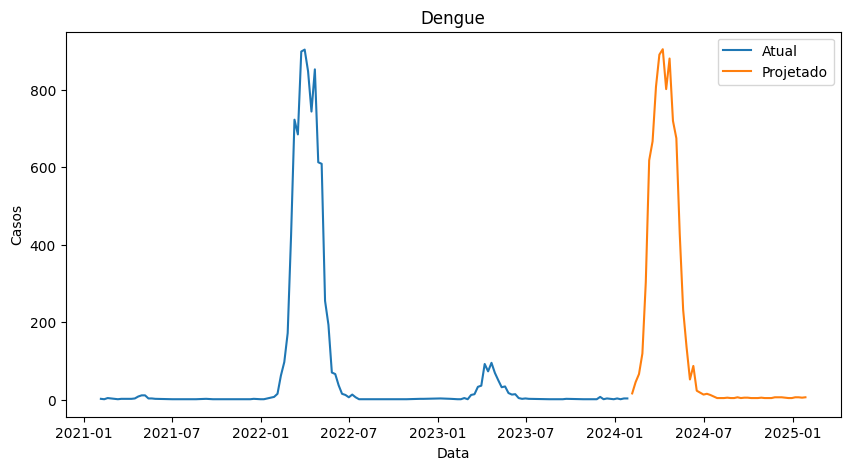

In [40]:
import matplotlib.pyplot as plt
altouruguai['data_notificacao'] = altouruguai['data_notificacao'].dt.to_period('W-THU')
altouruguai = altouruguai.groupby(['data_notificacao', 'regiao'])['quantidade_casos'].sum()
altouruguai = altouruguai.reset_index()
altouruguai['data_notificacao'] = altouruguai['data_notificacao'].dt.to_timestamp()
projections_combined['data_notificacao'] = pd.to_datetime(projections_combined['data_notificacao'])
plt.figure(figsize=(10, 5))
plt.plot(altouruguai['data_notificacao'], altouruguai['quantidade_casos'], label='Atual')
plt.plot(projections_combined['data_notificacao'], projections_combined['quantidade_casos'], label='Projetado')

plt.xlabel('Data')
plt.ylabel('Casos')
plt.title('Dengue')
plt.legend()
plt.show()

ALTO URUGUAI CATARINENSE

In [21]:
def project_macroregion_weekly(altouruguai, coluna_projetar, n_semanas):
    unique_municipio = altouruguai['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = altouruguai[altouruguai['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 1, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_altouruguai = project_macroregion_weekly(altouruguai, coluna_projetar, n_semanas)


projecao_semanal_altouruguai = projecao_semanal_altouruguai.dropna()

projecao_semanal_altouruguai['quantidade_casos'] = projecao_semanal_altouruguai['quantidade_casos'].abs() 

C:\Users\jesusda\AppData\Local\Temp\ipykernel_17264\3824874980.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jesusda\AppData\Local\Programs\Python\Pyt

In [22]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_altouruguai.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


VALE DO ITAJAI

In [23]:
def project_macroregion_weekly(valeitajai, coluna_projetar, n_semanas):
    unique_municipio = valeitajai['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = valeitajai[valeitajai['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_valeitajai = project_macroregion_weekly(valeitajai, coluna_projetar, n_semanas)


projecao_semanal_valeitajai = projecao_semanal_valeitajai.dropna()

projecao_semanal_valeitajai['quantidade_casos'] = projecao_semanal_valeitajai['quantidade_casos'].abs() 









C:\Users\jesusda\AppData\Local\Temp\ipykernel_17264\286223933.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jesusda\

In [24]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_valeitajai.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


CARBONIFERA

In [25]:
def project_macroregion_weekly(carbonifera, coluna_projetar, n_semanas):
    unique_municipio = carbonifera['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = carbonifera[carbonifera['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_carbonifera = project_macroregion_weekly(carbonifera, coluna_projetar, n_semanas)


projecao_semanal_carbonifera = projecao_semanal_carbonifera.dropna()

projecao_semanal_carbonifera['quantidade_casos'] = projecao_semanal_carbonifera['quantidade_casos'].abs() 






C:\Users\jesusda\AppData\Local\Temp\ipykernel_17264\643282259.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users

In [26]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_carbonifera.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


EXTREMO OESTE

In [27]:
def project_macroregion_weekly(extremooeste, coluna_projetar, n_semanas):
    unique_municipio = extremooeste['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = extremooeste[extremooeste['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_extremooeste = project_macroregion_weekly(extremooeste, coluna_projetar, n_semanas)


projecao_semanal_extremooeste = projecao_semanal_extremooeste.dropna()

projecao_semanal_extremooeste['quantidade_casos'] = projecao_semanal_extremooeste['quantidade_casos'].abs() 






C:\Users\jesusda\AppData\Local\Temp\ipykernel_17264\165836100.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jesusda\

In [28]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_extremooeste.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


EXTREMO SUL

In [6]:
def project_macroregion_weekly(extremosul, coluna_projetar, n_semanas):
    unique_municipio = extremosul['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = extremosul[extremosul['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (2, 0, 2) 
                    seasonal_order = (2, 0, 2, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_extremosul = project_macroregion_weekly(extremosul, coluna_projetar, n_semanas)

projecao_semanal_extremosul = projecao_semanal_extremosul.dropna()
projecao_semanal_extremosul['quantidade_casos'] = projecao_semanal_extremosul['quantidade_casos'].abs() 





C:\Users\jesusda\AppData\Local\Temp\ipykernel_14808\3642225071.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jesusda\AppData\Local\Programs\Python\Pyt

In [30]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_extremosul.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


FOZ DO RIO ITAJAI

In [31]:
def project_macroregion_weekly(fozdorio, coluna_projetar, n_semanas):
    unique_municipio = fozdorio['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = fozdorio[fozdorio['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_fozdorio = project_macroregion_weekly(fozdorio, coluna_projetar, n_semanas)


projecao_semanal_fozdorio = projecao_semanal_extremosul.dropna()

projecao_semanal_fozdorio['quantidade_casos'] = projecao_semanal_fozdorio['quantidade_casos'].abs() 

C:\Users\jesusda\AppData\Local\Temp\ipykernel_17264\2451329912.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
c:\Users\jesusda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\jesusda\AppData\Local\Temp\ipykernel_17264\2451329912.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_subset = data_subset.append({'data_notificacao': proxima_data, 

: 

In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_fozdorio.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()

GRANDE FLORIANOPOLIS

In [ ]:
def project_macroregion_weekly(grandefloripa, coluna_projetar, n_semanas):
    unique_municipio = grandefloripa['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = grandefloripa[grandefloripa['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_grandefloripa = project_macroregion_weekly(grandefloripa, coluna_projetar, n_semanas)


projecao_semanal_grandefloripa = projecao_semanal_grandefloripa.dropna()

projecao_semanal_grandefloripa['quantidade_casos'] = projecao_semanal_grandefloripa['quantidade_casos'].abs() 





In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_grandefloripa.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


LAGUNA

In [ ]:
def project_macroregion_weekly(laguna, coluna_projetar, n_semanas):
    unique_municipio = laguna['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = laguna[laguna['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_laguna = project_macroregion_weekly(laguna, coluna_projetar, n_semanas)


projecao_semanal_laguna = projecao_semanal_laguna.dropna()

projecao_semanal_laguna['quantidade_casos'] = projecao_semanal_laguna['quantidade_casos'].abs() 





In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_laguna.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


MEDIO VALE DO ITAJAI

In [ ]:
def project_macroregion_weekly(mediovaledoitajai, coluna_projetar, n_semanas):
    unique_municipio = mediovaledoitajai['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = mediovaledoitajai[mediovaledoitajai['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_mediovaledoitajai = project_macroregion_weekly(mediovaledoitajai, coluna_projetar, n_semanas)


projecao_semanal_mediovaledoitajai = projecao_semanal_mediovaledoitajai.dropna()

projecao_semanal_mediovaledoitajai['quantidade_casos'] = projecao_semanal_mediovaledoitajai['quantidade_casos'].abs() 






In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)
try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_mediovaledoitajai.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


MEIO OESTE

In [ ]:
def project_macroregion_weekly(meiooeste, coluna_projetar, n_semanas):
    unique_municipio = meiooeste['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = meiooeste[meiooeste['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_meiooeste = project_macroregion_weekly(meiooeste, coluna_projetar, n_semanas)


projecao_semanal_meiooeste = projecao_semanal_meiooeste.dropna()

projecao_semanal_meiooeste['quantidade_casos'] = projecao_semanal_meiooeste['quantidade_casos'].abs() 





In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_meiooeste.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


NORDESTE

In [ ]:
def project_macroregion_weekly(nordeste, coluna_projetar, n_semanas):
    unique_municipio = nordeste['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = nordeste[nordeste['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_nordeste = project_macroregion_weekly(nordeste, coluna_projetar, n_semanas)


projecao_semanal_nordeste = projecao_semanal_nordeste.dropna()

projecao_semanal_nordeste['quantidade_casos'] = projecao_semanal_nordeste['quantidade_casos'].abs() 





In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_nordeste.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


OESTE

In [ ]:
def project_macroregion_weekly(oeste, coluna_projetar, n_semanas):
    unique_municipio = oeste['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = oeste[oeste['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_oeste = project_macroregion_weekly(oeste, coluna_projetar, n_semanas)


projecao_semanal_oeste = projecao_semanal_oeste.dropna()

projecao_semanal_oeste['quantidade_casos'] = projecao_semanal_oeste['quantidade_casos'].abs() 




In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_oeste.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


PLANALTO NORTE

In [ ]:
def project_macroregion_weekly(planaltonorte, coluna_projetar, n_semanas):
    unique_municipio = planaltonorte['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = planaltonorte[planaltonorte['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_planaltonorte = project_macroregion_weekly(planaltonorte, coluna_projetar, n_semanas)


projecao_semanal_planaltonorte = projecao_semanal_planaltonorte.dropna()

projecao_semanal_planaltonorte['quantidade_casos'] = projecao_semanal_planaltonorte['quantidade_casos'].abs() 



In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_planaltonorte.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


SERRA CATARINENSE

In [ ]:
def project_macroregion_weekly(serracatarinense, coluna_projetar, n_semanas):
    unique_municipio = serracatarinense['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = serracatarinense[serracatarinense['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_serracatarinense = project_macroregion_weekly(serracatarinense, coluna_projetar, n_semanas)

projecao_semanal_serracatarinense = projecao_semanal_serracatarinense.dropna()

projecao_semanal_serracatarinense['quantidade_casos'] = projecao_semanal_serracatarinense['quantidade_casos'].abs() 



In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_serracatarinense.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


VALE DO ITAPOCU

In [ ]:
def project_macroregion_weekly(valedoitapocu, coluna_projetar, n_semanas):
    unique_municipio = valedoitapocu['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = valedoitapocu[valedoitapocu['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_valedoitapocu = project_macroregion_weekly(valedoitapocu, coluna_projetar, n_semanas)

projecao_semanal_valedoitapocu = projecao_semanal_valedoitapocu.dropna()

projecao_semanal_valedoitapocu['quantidade_casos'] = projecao_semanal_valedoitapocu['quantidade_casos'].abs() 



In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_valedoitapocu.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


XANXERE

In [ ]:
def project_macroregion_weekly(xanxere, coluna_projetar, n_semanas):
    unique_municipio = xanxere['regiao'].unique()
    projections = []
    for munincipio in unique_municipio:
        data_subset = xanxere[xanxere['regiao'] == munincipio]
        if data_subset.empty or 'data_notificacao' not in data_subset.columns:
            continue
        data_subset = data_subset.set_index('data_notificacao').resample('W-MON').sum().reset_index()
        for col in coluna_projetar:
            series = data_subset[col]
            current_series = series.copy()
            for i in range(n_semanas):
                try:
                    proxima_data = data_subset['data_notificacao'].max() + timedelta(days=7)
                    order = (1, 2, 1) 
                    seasonal_order = (1, 2, 1, 52) 
                    model = SARIMAX(current_series, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit(disp=False)
                    forecast_value = model_fit.get_forecast(steps=52).predicted_mean.values[0]
                    forecast_value = round(forecast_value, 0)
                    data_subset = data_subset.append({'data_notificacao': proxima_data, 'regiao': munincipio, col: forecast_value}, ignore_index=True)
                    #current_series = current_series.append(pd.Series([forecast_value], index=[proxima_data]))
                    current_series = pd.concat([current_series, pd.Series([forecast_value], index=[proxima_data])])
                except Exception as e:
                    print(f"Erro ao ajustar o modelo para {munincipio}, semana: {str(e)}")
            projections.append(data_subset)
    projections_combined = pd.concat(projections, ignore_index=True)
    return projections_combined

n_semanas = 52
coluna_projetar = ['quantidade_casos']
projecao_semanal_xanxere = project_macroregion_weekly(xanxere, coluna_projetar, n_semanas)


projecao_semanal_xanxere = projecao_semanal_xanxere.dropna()

projecao_semanal_xanxere['quantidade_casos'] = projecao_semanal_xanxere['quantidade_casos'].abs() 



In [ ]:
import psycopg2

conn = psycopg2.connect(
    database="*****",
    user="*****",
    password="*****",
    host="*****",
    port="****"
)

try:
    cursor = conn.cursor()
    conn.autocommit = False
    
    for index, row in projecao_semanal_xanxere.iterrows():
        cursor.execute(
            'INSERT INTO projetados.semana_imunologica_regioes '
            '("data_notificacao", "quantidade_casos", "regiao") '
            'VALUES (%s, %s, %s);',
            (
                row["data_notificacao"],
                row["quantidade_casos"],
                row["regiao"]
            )
        )
    conn.commit()
except Exception as e:
    conn.rollback()
    print("Erro:", e)
finally:
    cursor.close()
    conn.close()


PLOTS

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_current_vs_projected(current_data, projected_data, region_name, ax):
    """
    Plota os dados atuais vs. projetados para uma região específica.

    :param current_data: DataFrame com os dados atuais.
    :param projected_data: DataFrame com os dados projetados.
    :param region_name: Nome da região a ser plotada.
    :param ax: O eixo do subplot para desenhar o gráfico.
    """
    # Preparação dos dados atuais
    current = current_data[current_data['regiao'] == region_name]
    current['data_notificacao'] = pd.to_datetime(current['data_notificacao']).dt.to_period('W-THU').dt.to_timestamp()

    # Preparação dos dados projetados
    projected = projected_data[projected_data['regiao'] == region_name]
    projected['data_notificacao'] = pd.to_datetime(projected['data_notificacao'])

    # Plotagem
    ax.plot(current['data_notificacao'], current['quantidade_casos'], label='Atual', color='blue')
    ax.plot(projected['data_notificacao'], projected['quantidade_casos'], label='Projetado', linestyle='--', color='red')
    ax.set_xlabel('Data')
    ax.set_ylabel('Casos')
    ax.set_title(f'Dengue - {region_name}')
    ax.legend()

# Supondo que `data` é o DataFrame com seus dados atuais
# Supondo que `projecoes` é um dicionário com seus DataFrames projetados para cada região
projecoes = {
    'ALTO URUGUAI CATARINENSE': projecao_semanal_altouruguai,
    'ALTO VALE DO ITAJAÍ': projecao_semanal_valeitajai,
    'CARBONÍFERA': projecao_semanal_carbonifera,
    'EXTREMO OESTE': projecao_semanal_extremooeste,
    'EXTREMO SUL CATARINENSE': projecao_semanal_extremosul,
    'FOZ DO RIO ITAJAÍ': projecao_semanal_fozdorio,
    'GRANDE FLORIANÓPOLIS': projecao_semanal_grandefloripa,
    'LAGUNA': projecao_semanal_laguna,
    'MÉDIO VALE DO ITAJAÍ': projecao_semanal_mediovaledoitajai,
    'MEIO OESTE': projecao_semanal_meiooeste,
    'NORDESTE': projecao_semanal_nordeste,
    'OESTE': projecao_semanal_oeste,
    'PLANALTO NORTE': projecao_semanal_planaltonorte,
    'SERRA CATARINENSE':projecao_semanal_serracatarinense,
    'VALE DO ITAPOCU': projecao_semanal_valedoitapocu,
    'XANXERÊ': projecao_semanal_xanxere,
}

# Nomes das regiões
region_names = list(projecoes.keys())

# Criação dos subplots
fig, axs = plt.subplots(nrows=len(region_names), ncols=1, figsize=(10, 5 * len(region_names)))

# Verifica se axs é uma lista para o caso de ter apenas uma região
if not isinstance(axs, np.ndarray):
    axs = [axs]

# Plotagem para cada região
for ax, region_name in zip(axs, region_names):
    plot_current_vs_projected(data, projecoes[region_name], region_name, ax)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()


    

    
    
    
    
    
    
    
    
    
    
    
    
    
